In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [4]:
dataset, dataset_info = tfds.load("malaria",
                                  with_info=True,
                                 # split=['train[:80%]','train[80%:90%]','train[90%:]'],
                                 shuffle_files=True,)

In [5]:
#manual split  method
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    train_ds = dataset.take(int(DATASET_SIZE*TRAIN_RATIO))
    val_test_ds = dataset.skip(int(DATASET_SIZE*TRAIN_RATIO))
    val_ds = dataset.take(int(DATASET_SIZE*VAL_RATIO))
    test_ds = dataset.skip(int(DATASET_SIZE*VAL_RATIO))

    return train_ds, val_ds, test_ds

In [6]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1
train_ds, val_ds, test_ds = split(dataset['train'], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [7]:
dataset

{'train': <_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [8]:
# inbuilt splitting
# train_dataset = dataset[0]
# val_dataset = dataset[1]
# test_dataset = dataset[2]

In [9]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

22046
2755
24803


In [10]:
for i in val_ds.take(1):
    print(i)

{'image': <tf.Tensor: shape=(103, 103, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=1>}


In [11]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear im

In [12]:
def get_label_str(label):
    if label==0:
        return "Parasitized"
    else:
        return "Uninfected"

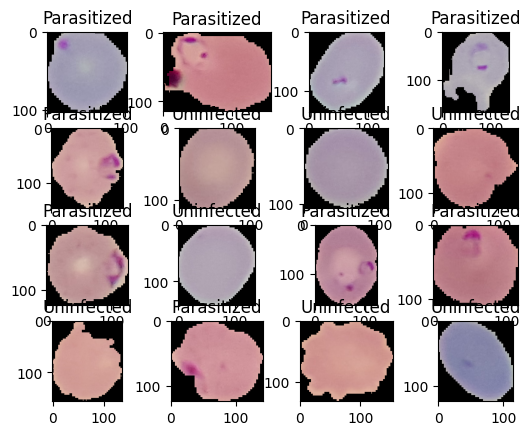

In [13]:
for i, sample in enumerate(train_ds.take(16)):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(sample['image'])
    plt.title(get_label_str(sample['label'].numpy()))

In [14]:
IM_SIZE = 224
BATCH_SIZE = 32

In [15]:
def resize_rescale(inputs):
    return tf.image.resize(inputs['image'], (IM_SIZE, IM_SIZE))/255.,inputs['label']

In [16]:
train_dataset = train_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_ds.map(resize_rescale).shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
for image, label in train_dataset.take(1):
    print(image, label)

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
 

In [18]:
np.unique(image)

array([0.0000000e+00, 2.4972958e-05, 2.5500556e-05, ..., 9.3656558e-01,
       9.3714768e-01, 9.3999696e-01], dtype=float32)

In [20]:
model = tf.keras.Sequential([
                             InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),

                             tf.keras.layers.Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation="relu"),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Conv2D(filters=16,kernel_size=3, strides=1, padding='valid', activation="relu"),
                             BatchNormalization(),
                             MaxPool2D(pool_size=2, strides=2),

                             Flatten(),
                             Dense(100, activation="relu"),
                             BatchNormalization(),
                             Dense(10, activation="relu"),
                             BatchNormalization(),
                             Dense(1, activation="sigmoid")

])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [21]:
model.compile(
    optimizer = Adam(learning_rate=0.01),
    loss = BinaryCrossentropy(),
    metrics = BinaryAccuracy()
)

In [23]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    verbose=1
)

Epoch 1/100
689/689 [==============================] - 41s 60ms/step - loss: 0.4093 - binary_accuracy: 0.8072 - val_loss: 0.3947 - val_binary_accuracy: 0.8733
Epoch 2/100
689/689 [==============================] - 32s 47ms/step - loss: 0.2127 - binary_accuracy: 0.9253 - val_loss: 0.1546 - val_binary_accuracy: 0.9470
Epoch 3/100
689/689 [==============================] - 34s 50ms/step - loss: 0.1817 - binary_accuracy: 0.9414 - val_loss: 0.1604 - val_binary_accuracy: 0.9623
Epoch 4/100
689/689 [==============================] - 32s 46ms/step - loss: 0.1605 - binary_accuracy: 0.9482 - val_loss: 0.2167 - val_binary_accuracy: 0.9350
Epoch 5/100
689/689 [==============================] - 36s 52ms/step - loss: 0.1502 - binary_accuracy: 0.9508 - val_loss: 0.1267 - val_binary_accuracy: 0.9601
Epoch 6/100
689/689 [==============================] - 32s 47ms/step - loss: 0.1350 - binary_accuracy: 0.9567 - val_loss: 0.0998 - val_binary_accuracy: 0.9695
Epoch 7/100
689/689 [=========================

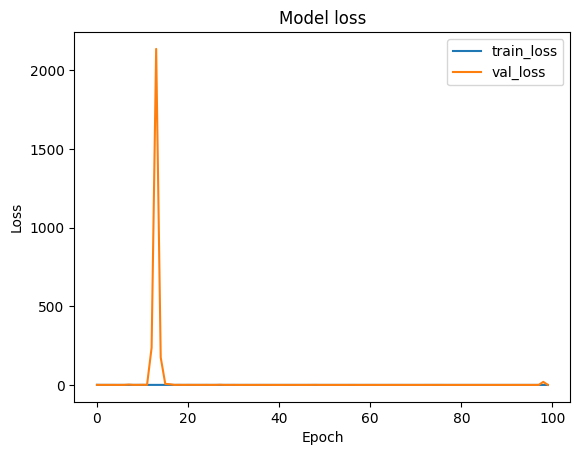

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

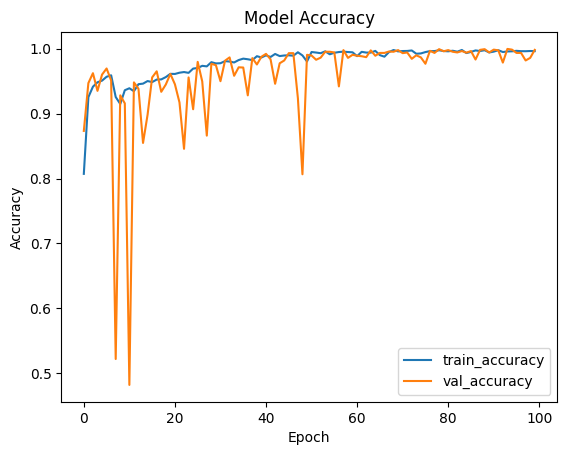

In [26]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [27]:
model.evaluate(test_dataset)

776/776 [==============================] - 32s 38ms/step - loss: 0.6962 - binary_accuracy: 0.9829


[0.6961636543273926, 0.9829456210136414]

In [28]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

In [29]:
print(parasite_or_not(model.predict(test_dataset.take(1))[0][0]))

1/1 [==============================] - 3s 3s/step
P


1/1 [==============================] - 0s 43ms/step


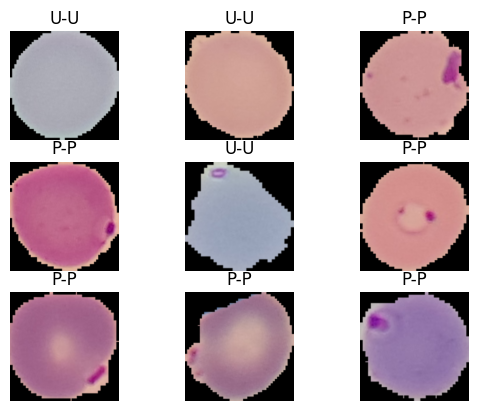

In [31]:
for image, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i])
        plt.title(parasite_or_not(label.numpy()[i]) + "-" + parasite_or_not(model.predict(image)[i][0]))
        plt.axis('off')